## Maiden Century Assignment (Apple Mobility Dataset)

> Author: Mohammad Harris Mansur

> Date: January 29, 2024

### Installing necessary libraries to run this notebook

* The requirements.txt file is present in the github repo

In [1]:
# !pip install -r requirements.txt 
# Commenting this out to not make the notebook too cluttered and unnecessarily long but this has been tested and will work

### Loading the required libraries below

In [2]:
import pandas as pd
import numpy as np
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

### Loading the datasets as Pandas DataFrames

Loading the apple mobility dataset in a dataframe called mobility_df
Using an external dataset in "COVID-19 Activity.csv". This dataset contains information about the state, county, date alongwith the total number of new COVID cases, the total number of new deaths, the overall total number of cases and the overall number of deaths. This dataset is meant to used to augment the analysis and also have target variables to train the model.

Target variable no. 1: Total number of new COVID cases
Target variable no. 2: Total number of new deaths because of COVID

In [3]:
mobility_df = pd.read_csv('./Data/apple_mobility_report_US.csv')
covid_activity_df = pd.read_csv('./Data/COVID-19 Activity.csv')

### Data Cleaning

In [4]:
unique_geo_types = list(mobility_df.geo_type.unique())
print(f'There are a total of {len(unique_geo_types)} unique geo_types in the dataset, mentioned below:')
for i in unique_geo_types:
    print(f'\t> {i}')

There are a total of 4 unique geo_types in the dataset, mentioned below:
	> county
	> city
	> sub-region
	> country/region


My first step is to retain the data for just the counties to streamline the analysis and get rid of other values (which is done below)

In [5]:
mobility_rel_df = mobility_df[mobility_df['geo_type'] == 'county']
mobility_rel_df.head()

,state,county_and_city,geo_type,date,driving,transit,walking
0,Alabama,Autauga County,county,2020-01-13,0.00,NaN,NaN
1,Alabama,Autauga County,county,2020-01-14,-0.86,NaN,NaN
2,Alabama,Autauga County,county,2020-01-15,13.51,NaN,NaN
3,Alabama,Autauga County,county,2020-01-16,23.01,NaN,NaN
4,Alabama,Autauga County,county,2020-01-17,50.98,NaN,NaN


To get an overall idea of the dataset, the total number of rows, columns, their datatypes, the number of missing values, I print the info() attribute of the dataframe which is shown below

In [6]:
mobility_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674846 entries, 0 to 1674845
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   state            1674846 non-null  object 
 1   county_and_city  1674846 non-null  object 
 2   geo_type         1674846 non-null  object 
 3   date             1674846 non-null  object 
 4   driving          1673952 non-null  float64
 5   transit          214828 non-null   float64
 6   walking          416414 non-null   float64
dtypes: float64(3), object(4)
memory usage: 89.4+ MB


We can see from the above printout that there are a lot of null values present in the columns transit and walking. To make the most out of our analysis, I have decided to keep only those combinations of state and counties which have the least number of missing values in these two columns

In [7]:
grouped = mobility_rel_df.groupby(['state', 'county_and_city'])

# Define a function to calculate missing values for a specific column in each group
def missing_values_in_specific_column(group, column_name):
    return group[column_name].isnull().sum()

# Specify the name of the specific column you're interested in
specific_column_name = ['transit', 'walking']

# Calculate the number of missing values for the specific column in each group
missing_values_in_specific_column_per_group = grouped.apply(missing_values_in_specific_column, specific_column_name)

# Find the group(s) with the least missing values in the specific column
min_missing_values = missing_values_in_specific_column_per_group.min()
selected_groups = missing_values_in_specific_column_per_group[missing_values_in_specific_column_per_group == min_missing_values]

# Print the selected groups
subset_data = selected_groups[(selected_groups['transit'] == 0) & (selected_groups['walking'] == 0)].reset_index()[['state', 'county_and_city']]
subset_data.head()


,state,county_and_city
0,Arizona,Maricopa County
1,Arizona,Pima County
2,California,Alameda County
3,California,Contra Costa County
4,California,Fresno County


From the above analysis, we find groups of state and county that have a total number of 0 missing values. They are stored in the dataframe: subset_data

To get the rows that have these combinations of state and county in our original dataset (mobility_rel_df), we merge the two dataframes on state and county_and_city (the column that has county information). I utilize an inner join so as to only keep those entries where there is a match.

In [8]:
## Getting state and county data with the most amount of information

mobility_rel_df = pd.merge(mobility_rel_df, subset_data, on=['state', 'county_and_city'], how='inner')
mobility_rel_df.head()


,state,county_and_city,geo_type,date,driving,transit,walking
0,Arizona,Maricopa County,county,2020-01-13,0.00,0.00,0.00
1,Arizona,Maricopa County,county,2020-01-14,4.29,6.54,1.77
2,Arizona,Maricopa County,county,2020-01-15,7.00,2.12,-2.84
3,Arizona,Maricopa County,county,2020-01-16,11.40,1.05,0.83
4,Arizona,Maricopa County,county,2020-01-17,26.60,5.30,20.64


Although we have lowered our chances of getting rows that have nan values, we have not eliminated them completely. Lets see how many missing values we have left in our dataset

In [9]:
print(f'There are a total of {len(mobility_rel_df.isna().sum())} rows in the dataset (out of a total of {len(mobility_rel_df)}) that have missing values!')

There are a total of 7 rows in the dataset (out of a total of 113088) that have missing values!


I then drop these missing values, as they will corrupt our analysis

In [10]:
## Drop rows with missing values

mobility_rel_df.dropna(inplace=True)

I now drop the word 'County' from the county_and_city column, to allow me to join it with my external dataset (COVID Activity). I also remove any additional whitespaces (which I found were present after looking at the dataset closely) using the .strip() function

In [11]:
mobility_rel_df['county_and_city'] = mobility_rel_df['county_and_city'].str.replace('County', '', case=False).str.strip()
mobility_rel_df.head()

,state,county_and_city,geo_type,date,driving,transit,walking
0,Arizona,Maricopa,county,2020-01-13,0.00,0.00,0.00
1,Arizona,Maricopa,county,2020-01-14,4.29,6.54,1.77
2,Arizona,Maricopa,county,2020-01-15,7.00,2.12,-2.84
3,Arizona,Maricopa,county,2020-01-16,11.40,1.05,0.83
4,Arizona,Maricopa,county,2020-01-17,26.60,5.30,20.64


I made a dashboard using plotly to compare the driving, walking and transit data over time for different states and counties. I made 2 such graphs incase we want to compare the changes in activity for different counties (like for instance counties that are metropolitan versus those that are not). This was just to play around with the data and to get a feel of the different changepoints so as to see where there were sharp changes. 

For example, there was a sharp change in all three activities around April 2020 (which shows that this must have been the first wave of COVID. There seems to be another sharp change around January 2021 which might be when the second wave hit. And then there seems to be a third wave around January 2022. Hence, this dashboard gives a good idea of the data that we have

In [12]:
df = mobility_rel_df.copy()
df['date'] = pd.to_datetime(df['date'])

# Create JupyterDash app
app = JupyterDash(__name__)

# App layout
app.layout = html.Div([
    html.H1("Transportation Trends Dashboard"),
    
    html.Label("Select State:"),
    dcc.Dropdown(
        id='state-dropdown',
        options=[{'label': state, 'value': state} for state in df['state'].unique()],
        value=df['state'].unique()[0],
        multi=False
    ),
    
    html.Label("Select County/City:"),
    dcc.Dropdown(
        id='county-dropdown',
        value=df['county_and_city'].unique()[0],
        multi=False
    ),
    
    dcc.Graph(id='line-plot')
])

# Update county dropdown options based on selected state
@app.callback(
    Output('county-dropdown', 'options'),
    [Input('state-dropdown', 'value')]
)
def update_county_options(selected_state):
    county_options = [{'label': county, 'value': county} for county in df[df['state'] == selected_state]['county_and_city'].unique()]
    return county_options

# Initialize line plot with default values
@app.callback(
    Output('line-plot', 'figure'),
    [Input('state-dropdown', 'value'),
     Input('county-dropdown', 'value')]
)
def update_line_plot(selected_state, selected_county):
    filtered_df = df[(df['state'] == selected_state) & (df['county_and_city'] == selected_county)]
    
    fig = px.line(filtered_df, x='date', y=['driving', 'transit', 'walking'],
                  labels={'value': 'Transportation Mode', 'date': 'Date'},
                  title=f'Transportation Trends in {selected_county}, {selected_state}')
    
    return fig

# Run the app in the notebook
app.run_server(mode='inline', port=8052)


### Feature Engineering (on the Apple Mobility Dataset)

I decide to engineer new features on the Apple Mobility Dataset. First, I change the date column to a datetime datatype to make further analyes simpler. 

I also decide to include the following features:

* Day of week: Since people generally follow similar routines on similar days, I decided to include this in my analysis. The data that we have are from changes in mobility of walking, public transit and driving and if people are going to work or to get groceries, they will have similar routines. For example, people who walk to work, will probably walk to work. People who take the bus, will probably take the bus etc.
* Month: I wanted to see if there was any monthly seasonality in these data
* Year: 2020 was the worst year for COVID because it took everyone by surprise and people generally became very cautious. I wanted to take into account this yearly variation as well
* Weekend or not: People generally like to go out and meet friends on the weekends and that is how COVID primarily spreads so this seemed like a good addition to help model COVID activity

In [13]:
mobility_rel_df['date'] = pd.to_datetime(mobility_rel_df['date'], format='%Y-%m-%d')

mobility_rel_df['day_of_week'] = mobility_rel_df['date'].dt.dayofweek
mobility_rel_df['month'] = mobility_rel_df['date'].dt.month
mobility_rel_df['year'] = mobility_rel_df['date'].dt.year
mobility_rel_df['is_weekend'] = mobility_rel_df['day_of_week'].isin([5, 6]).astype(int)


To get time-series related features, I wanted to sort the data (by date) but first grouping by state and county. This was done to sort of reset the dates everytime a new combination of state and group was encountered so that there was no data leakage between states/counties.

In [14]:
def sort_dates_within_group(group):
    return group.sort_values(by='date')

# Apply the function to each group
sorted_mobility_rel_df = mobility_rel_df.groupby(['state', 'county_and_city']).apply(sort_dates_within_group)

# Reset index after sorting
sorted_mobility_rel_df.reset_index(drop=True, inplace=True)

# Print the sorted DataFrame
sorted_mobility_rel_df.head()

,state,county_and_city,geo_type,date,driving,transit,walking,day_of_week,month,year,is_weekend
0,Arizona,Maricopa,county,2020-01-13,0.00,0.00,0.00,0,1,2020,0
1,Arizona,Maricopa,county,2020-01-14,4.29,6.54,1.77,1,1,2020,0
2,Arizona,Maricopa,county,2020-01-15,7.00,2.12,-2.84,2,1,2020,0
3,Arizona,Maricopa,county,2020-01-16,11.40,1.05,0.83,3,1,2020,0
4,Arizona,Maricopa,county,2020-01-17,26.60,5.30,20.64,4,1,2020,0


To capture temporal dependencies and patterns in the data and to capture autocorrelations and account for seasonality, I decided to include lagged features for driving, walking and transit. There is a lag of 1 to 7 values for each of the three features (introducing 7 new features for driving, walking and transit each). To make the code more readable, I decided to use a for loop to build the features

In [15]:
for i in range(7):
    sorted_mobility_rel_df[f'driving_lagged_{i+1}'] = sorted_mobility_rel_df.groupby(['state', 'county_and_city'])['driving'].shift(i+1)
    sorted_mobility_rel_df[f'transit_lagged_{i+1}'] = sorted_mobility_rel_df.groupby(['state', 'county_and_city'])['transit'].shift(i+1)
    sorted_mobility_rel_df[f'walking_lagged_{i+1}'] = sorted_mobility_rel_df.groupby(['state', 'county_and_city'])['walking'].shift(i+1)

This is what our dataset looks like now (after engineering some new features)

In [16]:
sorted_mobility_rel_df.tail()

,state,county_and_city,geo_type,date,driving,transit,walking,day_of_week,month,year,...,walking_lagged_4,driving_lagged_5,transit_lagged_5,walking_lagged_5,driving_lagged_6,transit_lagged_6,walking_lagged_6,driving_lagged_7,transit_lagged_7,walking_lagged_7
112779,Wisconsin,Milwaukee,county,2022-01-22,64.79,-13.03,151.20,5,1,2022,...,55.73,30.70,-18.02,48.77,21.57,-31.52,57.06,67.26,-15.24,158.69
112780,Wisconsin,Milwaukee,county,2022-01-23,18.49,-21.55,57.23,6,1,2022,...,65.87,36.48,-0.88,55.73,30.70,-18.02,48.77,21.57,-31.52,57.06
112781,Wisconsin,Milwaukee,county,2022-01-24,40.24,-1.72,64.11,0,1,2022,...,76.66,42.42,-12.03,65.87,36.48,-0.88,55.73,30.70,-18.02,48.77
112782,Wisconsin,Milwaukee,county,2022-01-25,34.67,-2.95,54.18,1,1,2022,...,144.62,45.45,-11.39,76.66,42.42,-12.03,65.87,36.48,-0.88,55.73
112783,Wisconsin,Milwaukee,county,2022-01-26,40.08,-10.60,54.43,2,1,2022,...,151.20,71.08,-5.94,144.62,45.45,-11.39,76.66,42.42,-12.03,65.87


I decided to engineer another set of 3 features (for driving, walking and transit). These are basically the difference of a particular column with itself (but a lag of 1 introduced to it). I wanted to include these to understand the rate of change of volume of each of the three types (driving, walking and transit). This will help give insight as to the acceleration of change which can help model important relationships in the data

In [17]:
sorted_mobility_rel_df['driving_diff_1'] = sorted_mobility_rel_df['driving'].diff()
sorted_mobility_rel_df['transit_diff_1'] = sorted_mobility_rel_df['transit'].diff()
sorted_mobility_rel_df['walking_diff_1'] = sorted_mobility_rel_df['walking'].diff()

sorted_mobility_rel_df.tail()


,state,county_and_city,geo_type,date,driving,transit,walking,day_of_week,month,year,...,walking_lagged_5,driving_lagged_6,transit_lagged_6,walking_lagged_6,driving_lagged_7,transit_lagged_7,walking_lagged_7,driving_diff_1,transit_diff_1,walking_diff_1
112779,Wisconsin,Milwaukee,county,2022-01-22,64.79,-13.03,151.20,5,1,2022,...,48.77,21.57,-31.52,57.06,67.26,-15.24,158.69,-6.29,-7.09,6.58
112780,Wisconsin,Milwaukee,county,2022-01-23,18.49,-21.55,57.23,6,1,2022,...,55.73,30.70,-18.02,48.77,21.57,-31.52,57.06,-46.30,-8.52,-93.97
112781,Wisconsin,Milwaukee,county,2022-01-24,40.24,-1.72,64.11,0,1,2022,...,65.87,36.48,-0.88,55.73,30.70,-18.02,48.77,21.75,19.83,6.88
112782,Wisconsin,Milwaukee,county,2022-01-25,34.67,-2.95,54.18,1,1,2022,...,76.66,42.42,-12.03,65.87,36.48,-0.88,55.73,-5.57,-1.23,-9.93
112783,Wisconsin,Milwaukee,county,2022-01-26,40.08,-10.60,54.43,2,1,2022,...,144.62,45.45,-11.39,76.66,42.42,-12.03,65.87,5.41,-7.65,0.25


Taking a look at our external dataset (COVID activity)

In [18]:
covid_activity_df.head()

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,3282,Lincoln,Oregon,2021-10-29,America,New York Times,1,41041.0,USA,United States,US,13,41
1,3282,Lincoln,Oregon,2021-10-30,America,New York Times,0,41041.0,USA,United States,US,0,41
2,3282,Lincoln,Oregon,2021-10-31,America,New York Times,0,41041.0,USA,United States,US,0,41
3,3305,Lincoln,Oregon,2021-11-01,America,New York Times,0,41041.0,USA,United States,US,23,41
4,3316,Lincoln,Oregon,2021-11-02,America,New York Times,2,41041.0,USA,United States,US,11,43


Before taking a deeper look into the dataset, I decide to filter the dataset keeping only the columns that I need for my analysis. Columns like CONTINENT_NAME, DATA_SOURCE_NAME, COUNTY_FIPS_NUMBER etc. are not important for our analysis and to keep the dataset small and usable, I decide to keep only the relevant columns. 

I also rename some of the columns in order to join the two datasets using Pandas

In [19]:
rel_cols = ['COUNTY_NAME', 'PROVINCE_STATE_NAME',
       'REPORT_DATE','PEOPLE_DEATH_NEW_COUNT',
       'PEOPLE_POSITIVE_NEW_CASES_COUNT']
covid_activity_rel_df = covid_activity_df[rel_cols].rename(columns={'COUNTY_NAME': 'county_and_city', 
                                                                    'PROVINCE_STATE_NAME':'state',
                                                                    'REPORT_DATE':'date'})
covid_activity_rel_df.head()

,county_and_city,state,date,PEOPLE_DEATH_NEW_COUNT,PEOPLE_POSITIVE_NEW_CASES_COUNT
0,Lincoln,Oregon,2021-10-29,1,13
1,Lincoln,Oregon,2021-10-30,0,0
2,Lincoln,Oregon,2021-10-31,0,0
3,Lincoln,Oregon,2021-11-01,0,23
4,Lincoln,Oregon,2021-11-02,2,11


### Data Cleaning (COVID Activity Dataset)

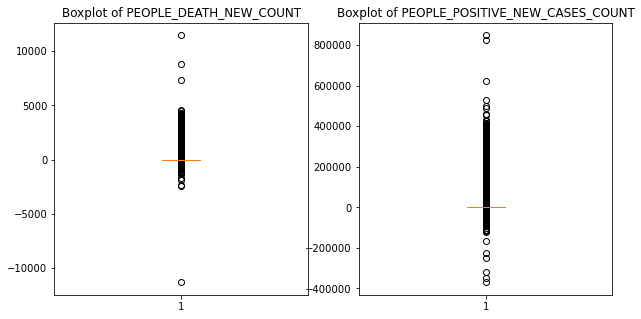

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first boxplot
axes[0].boxplot(covid_activity_rel_df['PEOPLE_DEATH_NEW_COUNT'])
axes[0].set_title('Boxplot of PEOPLE_DEATH_NEW_COUNT')

# Plot the second boxplot
axes[1].boxplot(covid_activity_rel_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])
axes[1].set_title('Boxplot of PEOPLE_POSITIVE_NEW_CASES_COUNT')

# Display the plot
plt.show()

As we can see from the two boxplots above, there are some values in these columns that are less than 0. Since the number of new covid cases / deaths can not be less than 0, I decide to filter these out

In [21]:
covid_activity_rel_df = covid_activity_rel_df[covid_activity_rel_df['PEOPLE_DEATH_NEW_COUNT'] >= 0]

Converting the date column in covid_activity_rel_df to datetime datatype for standardization and for ease of analysis, later on

In [22]:
covid_activity_rel_df['date'] = pd.to_datetime(covid_activity_rel_df['date'], format='%Y-%m-%d')


### Merging the two datasets together

I am now going to merge the apple mobility dataset with the covid activity dataset, merging on the following information: county, state and date. This will help ensure a correct merging of the two datasets such that we have information of the new number of cases / deaths in each particular county/state combination for each date present in the two datasets

In [23]:
merged_df = pd.merge(sorted_mobility_rel_df, covid_activity_rel_df, on=['county_and_city', 'state', 'date'], how='inner')
print(f'There are a total of {len(merged_df)} rows in the merged dataset!')

There are a total of 102175 rows in the merged dataset!


Taking a look at what our merged dataset looks like, just for a sanity check. As we can see below, the columns with information about the new number of cases/deaths is now present in this dataset

In [24]:
merged_df.tail()

,state,county_and_city,geo_type,date,driving,transit,walking,day_of_week,month,year,...,transit_lagged_6,walking_lagged_6,driving_lagged_7,transit_lagged_7,walking_lagged_7,driving_diff_1,transit_diff_1,walking_diff_1,PEOPLE_DEATH_NEW_COUNT,PEOPLE_POSITIVE_NEW_CASES_COUNT
102170,Wisconsin,Milwaukee,county,2022-01-22,64.79,-13.03,151.20,5,1,2022,...,-31.52,57.06,67.26,-15.24,158.69,-6.29,-7.09,6.58,0,0
102171,Wisconsin,Milwaukee,county,2022-01-23,18.49,-21.55,57.23,6,1,2022,...,-18.02,48.77,21.57,-31.52,57.06,-46.30,-8.52,-93.97,0,0
102172,Wisconsin,Milwaukee,county,2022-01-24,40.24,-1.72,64.11,0,1,2022,...,-0.88,55.73,30.70,-18.02,48.77,21.75,19.83,6.88,6,2439
102173,Wisconsin,Milwaukee,county,2022-01-25,34.67,-2.95,54.18,1,1,2022,...,-12.03,65.87,36.48,-0.88,55.73,-5.57,-1.23,-9.93,51,627
102174,Wisconsin,Milwaukee,county,2022-01-26,40.08,-10.60,54.43,2,1,2022,...,-11.39,76.66,42.42,-12.03,65.87,5.41,-7.65,0.25,4,733


### Feature Engineering (on the merged dataset)

I wanted to see if there was an autocorrelation or temporal dependency of the target variables with themselves. To analyze this, I decided to introduce a lagged version of the target variables (new number of cases and new number of deaths) to the merged dataset. I introduced a lag 1, lag 2 and lag 3 version such that for each of the two target variables that we have, we introduced three new features to our dataset

In [25]:
for i in range(14):
    merged_df[f'new_deaths_diff_{i+1}'] = merged_df.groupby(['state', 'county_and_city'])['PEOPLE_DEATH_NEW_COUNT'].shift(i+1)
    merged_df[f'new_cases_diff_{i+1}'] = merged_df.groupby(['state', 'county_and_city'])['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(i+1)
merged_df.tail()

,state,county_and_city,geo_type,date,driving,transit,walking,day_of_week,month,year,...,new_deaths_diff_10,new_cases_diff_10,new_deaths_diff_11,new_cases_diff_11,new_deaths_diff_12,new_cases_diff_12,new_deaths_diff_13,new_cases_diff_13,new_deaths_diff_14,new_cases_diff_14
102170,Wisconsin,Milwaukee,county,2022-01-22,64.79,-13.03,151.20,5,1,2022,...,0.0,6091.0,5.0,2380.0,20.0,9719.0,0.0,0.0,0.0,0.0
102171,Wisconsin,Milwaukee,county,2022-01-23,18.49,-21.55,57.23,6,1,2022,...,3.0,2014.0,0.0,6091.0,5.0,2380.0,20.0,9719.0,0.0,0.0
102172,Wisconsin,Milwaukee,county,2022-01-24,40.24,-1.72,64.11,0,1,2022,...,3.0,5394.0,3.0,2014.0,0.0,6091.0,5.0,2380.0,20.0,9719.0
102173,Wisconsin,Milwaukee,county,2022-01-25,34.67,-2.95,54.18,1,1,2022,...,0.0,0.0,3.0,5394.0,3.0,2014.0,0.0,6091.0,5.0,2380.0
102174,Wisconsin,Milwaukee,county,2022-01-26,40.08,-10.60,54.43,2,1,2022,...,0.0,0.0,0.0,0.0,3.0,5394.0,3.0,2014.0,0.0,6091.0


For the next set of features, I conducted some research on how quickly COVID spreads. In most of the articles that I reviewed, I found that people generally began to notice symptoms of COVID between 7 to 14 days after infection. This meant that if 100 people got COVID, the extent of COVID that they spread would be noticeable between 7-14 days after they started developing symptoms. This is why I decided to include a rolling average of 7 and a rolling average of 14 previous rows (prior dates) for each of the two target variables (PEOPLE_POSITIVE_NEW_CASES_COUNT and PEOPLE_DEATH_NEW_COUNT)

In [26]:
## Rolling average

# Define a function to calculate rolling average for two columns within each group
def rolling_avg_group_7(group):
    group['rolling_average_new_cases_7'] = group['PEOPLE_POSITIVE_NEW_CASES_COUNT'].rolling(window=7, min_periods=1).mean()
    group['rolling_average_new_deaths_7'] = group['PEOPLE_DEATH_NEW_COUNT'].rolling(window=7, min_periods=1).mean()
    return group

def rolling_avg_group_14(group):
    group['rolling_average_new_cases_14'] = group['PEOPLE_POSITIVE_NEW_CASES_COUNT'].rolling(window=14, min_periods=1).mean()
    group['rolling_average_new_deaths_14'] = group['PEOPLE_DEATH_NEW_COUNT'].rolling(window=14, min_periods=1).mean()
    return group

# Apply the rolling_avg_group function to each group defined by 'state' and 'county_and_city'
merged_df = merged_df.groupby(['state', 'county_and_city']).apply(rolling_avg_group_7).reset_index(drop=True)
merged_df = merged_df.groupby(['state', 'county_and_city']).apply(rolling_avg_group_14).reset_index(drop=True)

merged_df.tail()


,state,county_and_city,geo_type,date,driving,transit,walking,day_of_week,month,year,...,new_deaths_diff_12,new_cases_diff_12,new_deaths_diff_13,new_cases_diff_13,new_deaths_diff_14,new_cases_diff_14,rolling_average_new_cases_7,rolling_average_new_deaths_7,rolling_average_new_cases_14,rolling_average_new_deaths_14
102170,Wisconsin,Milwaukee,county,2022-01-22,64.79,-13.03,151.20,5,1,2022,...,20.0,9719.0,0.0,0.0,0.0,0.0,3799.571429,3.285714,3728.214286,3.857143
102171,Wisconsin,Milwaukee,county,2022-01-23,18.49,-21.55,57.23,6,1,2022,...,5.0,2380.0,20.0,9719.0,0.0,0.0,3799.571429,3.285714,3728.214286,3.857143
102172,Wisconsin,Milwaukee,county,2022-01-24,40.24,-1.72,64.11,0,1,2022,...,0.0,6091.0,5.0,2380.0,20.0,9719.0,1434.714286,3.285714,3208.214286,2.857143
102173,Wisconsin,Milwaukee,county,2022-01-25,34.67,-2.95,54.18,1,1,2022,...,3.0,2014.0,0.0,6091.0,5.0,2380.0,1097.714286,9.714286,3083.000000,6.142857
102174,Wisconsin,Milwaukee,county,2022-01-26,40.08,-10.60,54.43,2,1,2022,...,3.0,5394.0,3.0,2014.0,0.0,6091.0,992.857143,9.714286,2700.285714,6.428571


To help augment the analysis, I decided to use a bunch of other statistical measures. These include the min, max, standard deviation and kurtosis of the last 7 values. Kurtosis was taking a long time to compute so I decided to leave that measure commented out. I would have also liked to fit a regression line for the last 7 values and include its gradient as a feature to see if there was an upward or downward trend and the strength of that trend. But there were some errors in that and I did not have enough time to debug my code

Note that I took great care to calculate these features for each group of state and county. This is to avoid any data leakage or any information from moving from one county to the other and corrupt our analysis

In [27]:
def min_last_7_values(group):
    return group.shift(1).rolling(window=7, min_periods=1).min()
def max_last_7_values(group):
    return group.shift(1).rolling(window=7, min_periods=1).max()
def std_last_7_values(group):
    return group.shift(1).rolling(window=7, min_periods=1).max()
def kurtosis_last_7_values(group):
    return group.shift(1).rolling(window=7, min_periods=1).apply(lambda x: pd.Series(x).kurtosis())


# Apply the function to each group
merged_df['min_last_7_new_cases'] = merged_df.groupby(['state', 'county_and_city'])['PEOPLE_POSITIVE_NEW_CASES_COUNT'].apply(min_last_7_values)
merged_df['min_last_7_new_deaths'] = merged_df.groupby(['state', 'county_and_city'])['PEOPLE_DEATH_NEW_COUNT'].apply(min_last_7_values)

merged_df['max_last_7_new_cases'] = merged_df.groupby(['state', 'county_and_city'])['PEOPLE_POSITIVE_NEW_CASES_COUNT'].apply(max_last_7_values)
merged_df['max_last_7_new_deaths'] = merged_df.groupby(['state', 'county_and_city'])['PEOPLE_DEATH_NEW_COUNT'].apply(max_last_7_values)

merged_df['std_last_7_new_cases'] = merged_df.groupby(['state', 'county_and_city'])['PEOPLE_POSITIVE_NEW_CASES_COUNT'].apply(std_last_7_values)
merged_df['std_last_7_new_deaths'] = merged_df.groupby(['state', 'county_and_city'])['PEOPLE_DEATH_NEW_COUNT'].apply(std_last_7_values)

# merged_df['kurtosis_last_7_new_cases'] = merged_df.groupby(['state', 'county_and_city'])['PEOPLE_POSITIVE_NEW_CASES_COUNT'].apply(kurtosis_last_7_values)
# merged_df['kurtosis_last_7_new_deaths'] = merged_df.groupby(['state', 'county_and_city'])['PEOPLE_DEATH_NEW_COUNT'].apply(kurtosis_last_7_values)

merged_df.tail()

,state,county_and_city,geo_type,date,driving,transit,walking,day_of_week,month,year,...,rolling_average_new_cases_7,rolling_average_new_deaths_7,rolling_average_new_cases_14,rolling_average_new_deaths_14,min_last_7_new_cases,min_last_7_new_deaths,max_last_7_new_cases,max_last_7_new_deaths,std_last_7_new_cases,std_last_7_new_deaths
102170,Wisconsin,Milwaukee,county,2022-01-22,64.79,-13.03,151.20,5,1,2022,...,3799.571429,3.285714,3728.214286,3.857143,0.0,0.0,18993.0,6.0,18993.0,6.0
102171,Wisconsin,Milwaukee,county,2022-01-23,18.49,-21.55,57.23,6,1,2022,...,3799.571429,3.285714,3728.214286,3.857143,0.0,0.0,18993.0,6.0,18993.0,6.0
102172,Wisconsin,Milwaukee,county,2022-01-24,40.24,-1.72,64.11,0,1,2022,...,1434.714286,3.285714,3208.214286,2.857143,0.0,0.0,18993.0,6.0,18993.0,6.0
102173,Wisconsin,Milwaukee,county,2022-01-25,34.67,-2.95,54.18,1,1,2022,...,1097.714286,9.714286,3083.000000,6.142857,0.0,0.0,2986.0,6.0,2986.0,6.0
102174,Wisconsin,Milwaukee,county,2022-01-26,40.08,-10.60,54.43,2,1,2022,...,992.857143,9.714286,2700.285714,6.428571,0.0,0.0,2439.0,51.0,2439.0,51.0


Because we introduced a number of different lagged features, they were bound to introduce some missing values. For example the first n-1 values after shifting the series by n values would be missing (by definition of shifting). I decided to filter these missing values out

In [28]:
merged_df.dropna(inplace=True)

In [29]:
print(f'We have a total of {len(merged_df)} rows in our merged dataset now!')

We have a total of 100201 rows in our merged dataset now!


To check if there is any seasonality based on the day of week and to make our graphs more readable, I decided to include a day map that would simply map the day_of_week values to actual names of the days and then plotted the mean values of Driving, Walking and Transit for each of the 7 days of the week below

In [30]:
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
merged_df['day_name'] = merged_df['day_of_week'].map(day_map)


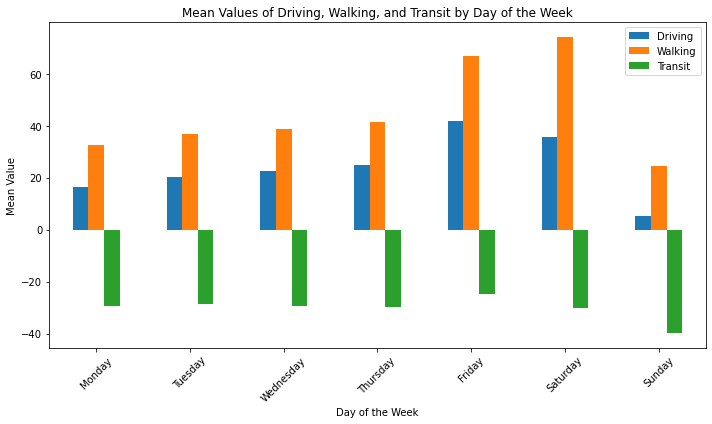

In [31]:
# Group by 'day_name' and calculate the mean values
mean_values = merged_df.groupby('day_name').mean()

# Define the order of days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Sort the mean_values DataFrame based on the order of days
mean_values_sorted = mean_values.reindex(days_order)

# Plot side-by-side bar charts
mean_values_sorted[['driving', 'walking', 'transit']].plot(kind='bar', figsize=(10, 6))

# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Mean Value')
plt.title('Mean Values of Driving, Walking, and Transit by Day of the Week')

# Display the plot
plt.legend(['Driving', 'Walking', 'Transit'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As we can see, this reveals some interesting trends. Transit comes out to be negative for all days, which proves that people generally use less and less of public transit during COVID (to avoid spreading or catching the virus from other people). Walking was generally more positive than Driving because by keeping a safe distance, people like to go out (the highest values are on Friday and Saturday). There seems to be a certain seasonality to this graph with values generally becoming more positive till Friday and Saturday and then decreasing on Sunday

For all the different counties in our dataset of New York, I plotted the new number of cases of COVID and a rolling average of the previous 7 values. This was just to see if the rolling average was indeed smoothing out the data and followed a similar pattern. This also shows that this can be used as a feature to train our model at the end

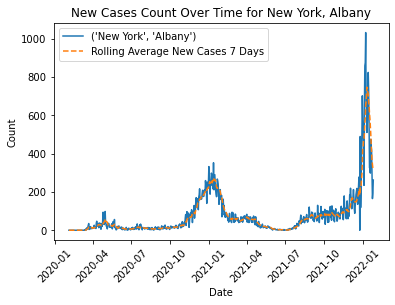

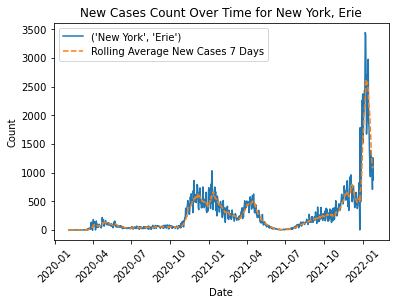

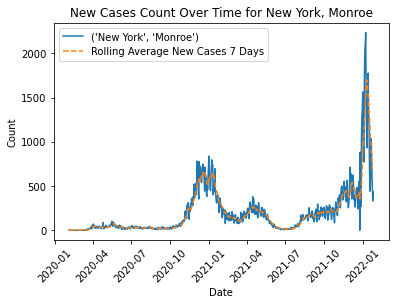

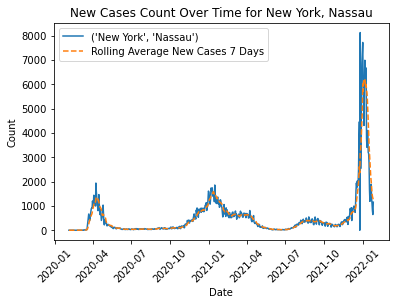

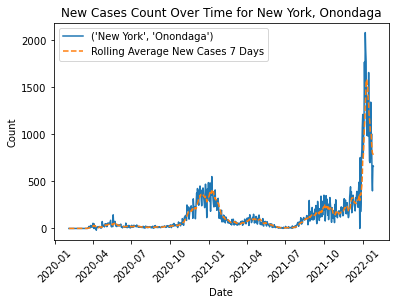

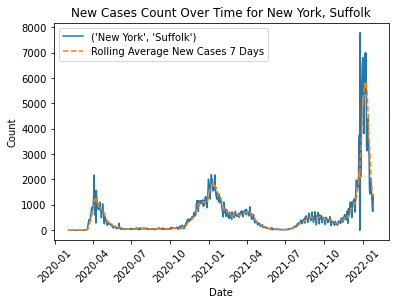

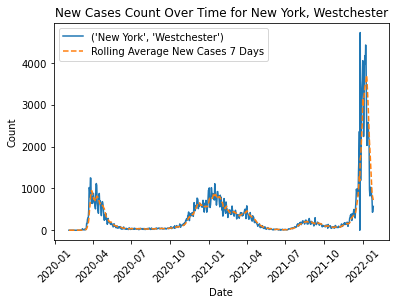

In [32]:
grouped = merged_df[merged_df['state'] == 'New York'].groupby(['state', 'county_and_city'])

# Plot for each group
for name, group in grouped:
    plt.figure()
    plt.plot(group['date'], group['PEOPLE_POSITIVE_NEW_CASES_COUNT'], label=name)
    plt.plot(group['date'], group['rolling_average_new_cases_7'], label='Rolling Average New Cases 7 Days', linestyle='--')
    
    plt.title(f'New Cases Count Over Time for {name[0]}, {name[1]}')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

I then decided to plot Autocorrelation and Partial Autocorrelation plots to get a better idea of the correlation between the target variables and their lagged values. As we can see below, there is a seasonality for the column PEOPLE_POSITIVE_NEW_CASES_COUNT (the new number of cases everyday). And there seems to be the max amount of correlation between the series and a lag 7 version of itself (the next highest being a correlation of the series and the lag 14 version of itself). This further strengthens the research that I did (mentioned previously)

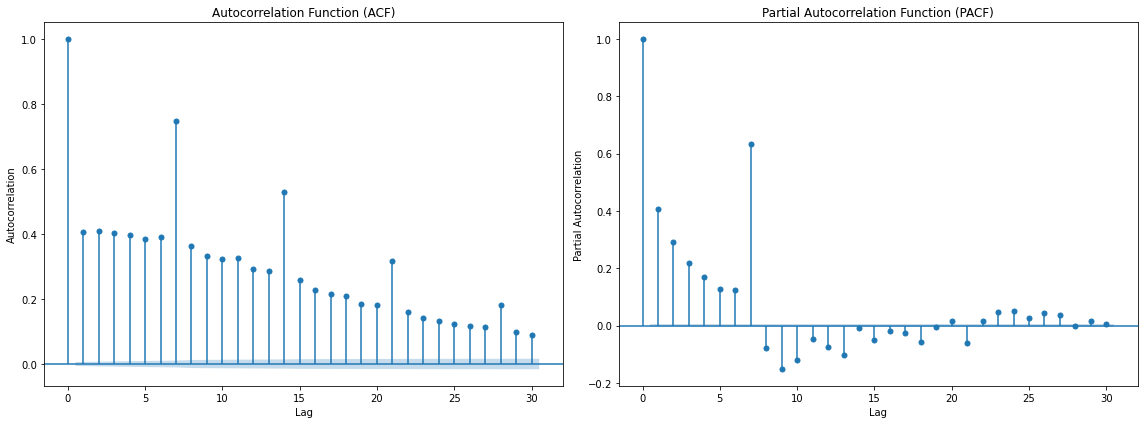

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot ACF
plot_acf(merged_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

# Plot PACF
plot_pacf(merged_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')

# Display the plot
plt.tight_layout()
plt.show()


I plotted the ACF and PACF for PEOPLE_DEATH_NEW_COUNT now to see if there was any seasonality to it. As we can see below, there is a seasonality component here as well. This further strengthens that these lagged features that we included are going to prove helpful in our model that we develop later on

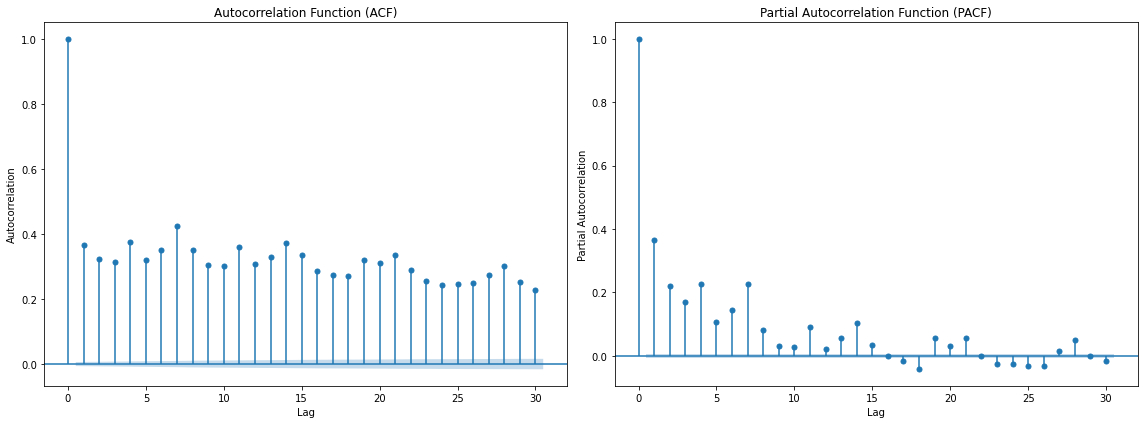

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot ACF
plot_acf(merged_df['PEOPLE_DEATH_NEW_COUNT'], lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

# Plot PACF
plot_pacf(merged_df['PEOPLE_DEATH_NEW_COUNT'], lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')

# Display the plot
plt.tight_layout()
plt.show()

To see how the data was behaving, I decided to use the describe() method of a Pandas dataframe. This generally tells the variation in the data, and we have included most of these variables in our analysis. Only the percentiles are missing

In [35]:
merged_df.describe()

,driving,transit,walking,day_of_week,month,year,is_weekend,driving_lagged_1,transit_lagged_1,walking_lagged_1,...,rolling_average_new_cases_7,rolling_average_new_deaths_7,rolling_average_new_cases_14,rolling_average_new_deaths_14,min_last_7_new_cases,min_last_7_new_deaths,max_last_7_new_cases,max_last_7_new_deaths,std_last_7_new_cases,std_last_7_new_deaths
count,100201.000000,100201.000000,100201.000000,100201.000000,100201.000000,100201.000000,100201.000000,100201.000000,100201.000000,100201.000000,...,100201.000000,100201.000000,100201.000000,100201.000000,100201.000000,100201.000000,100201.000000,100201.00000,100201.000000,100201.00000
mean,23.808613,-30.269938,44.941181,3.006846,6.583906,2020.577529,0.287552,23.803034,-30.249575,44.930637,...,311.040097,3.484654,300.027403,3.454593,96.197772,0.473199,732.372701,9.29853,732.372701,9.29853
std,34.821719,31.646949,57.230989,1.999534,3.433742,0.562465,0.452623,34.848414,31.597774,57.265022,...,913.638069,8.383814,852.747896,7.937764,543.010960,2.820654,2731.508208,26.88755,2731.508208,26.88755
min,-85.170000,-97.240000,-99.000000,0.000000,1.000000,2020.000000,0.000000,-85.170000,-97.240000,-99.000000,...,-1364.285714,0.000000,-309.357143,0.000000,-18817.000000,0.000000,0.000000,0.00000,0.000000,0.00000
25%,1.960000,-50.730000,9.450000,1.000000,4.000000,2020.000000,0.000000,1.880000,-50.730000,9.250000,...,38.142857,0.428571,38.214286,0.500000,0.000000,0.000000,71.000000,2.00000,71.000000,2.00000
50%,24.300000,-33.800000,43.420000,3.000000,7.000000,2021.000000,0.000000,24.280000,-33.770000,43.410000,...,111.857143,1.428571,111.142857,1.428571,8.000000,0.000000,205.000000,4.00000,205.000000,4.00000
75%,47.230000,-12.930000,76.540000,5.000000,10.000000,2021.000000,1.000000,47.250000,-12.840000,76.600000,...,288.571429,3.571429,283.928571,3.500000,78.000000,0.000000,549.000000,9.00000,549.000000,9.00000
max,426.850000,679.040000,1392.380000,6.000000,12.000000,2022.000000,1.000000,426.850000,679.040000,1392.380000,...,41682.000000,241.285714,38993.357143,221.142857,35244.000000,137.000000,110441.000000,1258.00000,110441.000000,1258.00000


To further aid my analysis, I decided to check the correlation among a few different variables. I tried a number of different combinations but only including this to not clutter the notebook a lot

In [36]:
## Correlation analysis

correlation_matrix = merged_df[['driving', 'transit', 'walking', 
                         'new_cases_diff_7', 'new_deaths_diff_7', 
                         'new_cases_diff_14', 'new_deaths_diff_14',
                         'rolling_average_new_cases_7', 
                         'rolling_average_new_deaths_7',
                         'PEOPLE_POSITIVE_NEW_CASES_COUNT', 
                         'PEOPLE_DEATH_NEW_COUNT']].corr()
correlation_matrix


,driving,transit,walking,new_cases_diff_7,new_deaths_diff_7,new_cases_diff_14,new_deaths_diff_14,rolling_average_new_cases_7,rolling_average_new_deaths_7,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_NEW_COUNT
driving,1.000000,0.595527,0.829354,0.002862,-0.068397,-0.002828,-0.056344,-0.011882,-0.135895,0.009659,-0.075475
transit,0.595527,1.000000,0.644882,0.029935,-0.066054,0.021041,-0.062390,0.034160,-0.114180,0.035020,-0.067065
walking,0.829354,0.644882,1.000000,0.000162,-0.054381,-0.004887,-0.045335,-0.002555,-0.097944,0.006802,-0.059358
new_cases_diff_7,0.002862,0.029935,0.000162,1.000000,0.211052,0.819571,0.168321,0.653293,0.298218,0.794454,0.225347
new_deaths_diff_7,-0.068397,-0.066054,-0.054381,0.211052,1.000000,0.241418,0.426436,0.230951,0.538182,0.167666,0.428472
new_cases_diff_14,-0.002828,0.021041,-0.004887,0.819571,0.241418,1.000000,0.229125,0.593569,0.367554,0.669030,0.267375
new_deaths_diff_14,-0.056344,-0.062390,-0.045335,0.168321,0.426436,0.229125,1.000000,0.190618,0.511442,0.136992,0.379425
rolling_average_new_cases_7,-0.011882,0.034160,-0.002555,0.653293,0.230951,0.593569,0.190618,1.000000,0.391498,0.704930,0.280156
rolling_average_new_deaths_7,-0.135895,-0.114180,-0.097944,0.298218,0.538182,0.367554,0.511442,0.391498,1.000000,0.256115,0.661201
PEOPLE_POSITIVE_NEW_CASES_COUNT,0.009659,0.035020,0.006802,0.794454,0.167666,0.669030,0.136992,0.704930,0.256115,1.000000,0.214439


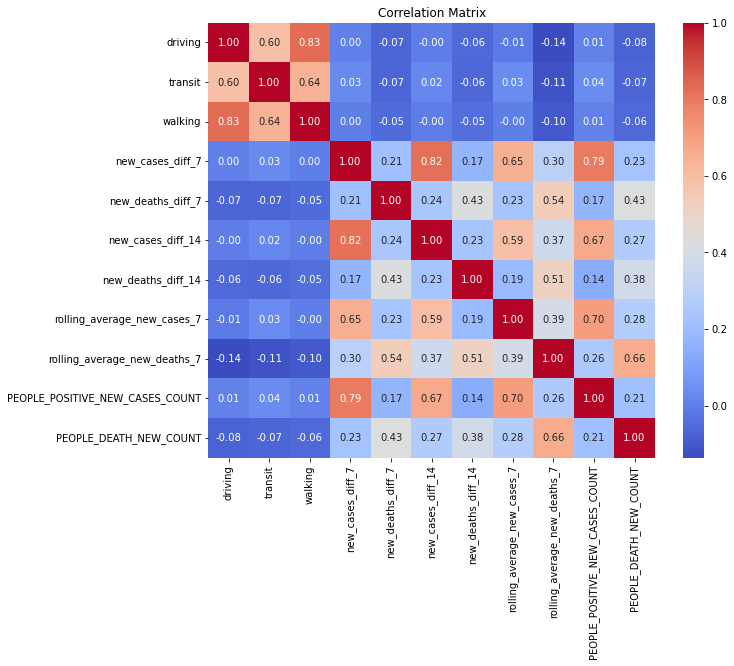

In [37]:
## Correlation heatmap for better visualization

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


To move on to modeling the data, and knowing which variables we would like to one-hot encode, I decided to print out a list of columns that are of object datatype. One exception not shown here is the year, month and day_of_week columns which I will be one-hot encoding as well.

In [38]:
object_columns = merged_df.select_dtypes(include='object').columns

In [39]:
print('These are the columns, listed below')
for i in list(object_columns):
    print(f'\t> {i}')

These are the columns, listed below
	> state
	> county_and_city
	> geo_type
	> day_name


Making a copy of the merged_df dataframe for modeling purposes and to ensure that I dont have to rerun all prior cells if I change something in the master dataset of merged_df

In [40]:
df = merged_df.copy()

Dropping columns like geo_type, date and day_name that I dont need for my analysis

In [41]:
columns_to_drop = ['geo_type', 'date', 'day_name']

df.drop(columns=columns_to_drop, inplace=True)

## Model Training

Making a copy of the df dataframe called data which I will be using to train my models

In [42]:
data = df.copy()

One-hot encoding the categorical variables to ensure the analysis is done propoerly

In [43]:
# Columns to one-hot encode
columns_to_encode = ['day_of_week', 'month', 'year', 'state', 'county_and_city']

one_hot = pd.get_dummies(data[columns_to_encode])



Concatenating the one-hot encoded features to our original dataset to enrich the feature space

In [44]:
data = pd.concat([data, one_hot], axis=1)
data.drop(columns = columns_to_encode, inplace=True)
data.head()

,driving,transit,walking,is_weekend,driving_lagged_1,transit_lagged_1,walking_lagged_1,driving_lagged_2,transit_lagged_2,walking_lagged_2,...,county_and_city_Ventura,county_and_city_Wake,county_and_city_Washington,county_and_city_Washoe,county_and_city_Washtenaw,county_and_city_Wayne,county_and_city_Westchester,county_and_city_Whatcom,county_and_city_Worcester,county_and_city_Yolo
14,5.18,0.74,-10.46,0,0.08,-2.53,-11.77,-22.25,-27.91,-13.02,...,0,0,0,0,0,0,0,0,0,0
15,4.60,0.94,-11.76,0,5.18,0.74,-10.46,0.08,-2.53,-11.77,...,0,0,0,0,0,0,0,0,0,0
16,9.04,-1.00,-4.77,0,4.60,0.94,-11.76,5.18,0.74,-10.46,...,0,0,0,0,0,0,0,0,0,0
17,27.57,9.64,28.06,0,9.04,-1.00,-4.77,4.60,0.94,-11.76,...,0,0,0,0,0,0,0,0,0,0
18,24.68,0.36,39.89,1,27.57,9.64,28.06,9.04,-1.00,-4.77,...,0,0,0,0,0,0,0,0,0,0


Checking if there are any null values in the final dataframe called data, that we have

In [45]:
data.isna().sum().sum()

0

Creating numpy arrays for the features (stored in X), target variables: new deaths (stored in y_death) and new cases (stored in y_cases)

In [46]:
# Separate target variables
y_death = data['PEOPLE_DEATH_NEW_COUNT'].values
y_cases = data['PEOPLE_POSITIVE_NEW_CASES_COUNT'].values

X = data.drop(['PEOPLE_DEATH_NEW_COUNT', 'PEOPLE_POSITIVE_NEW_CASES_COUNT'], axis=1).values


Dividing the feature values and target variables in a training and test set. 80% of the values are kept for training the model and 20% are used for testing the model

In [47]:
X_train, X_test, y_death_train, y_death_test, y_cases_train, y_cases_test = train_test_split(X, y_death, y_cases, test_size=0.2, random_state=42)


Creating an lstm model to train on the training data that we have divided our original data into. I tried a number of different models but this simple model got better results than the other more complex models. I only trained on 10 epochs because of resource constraints, I would have liked to train it on a higher number of epochs and evaluate the results for each to see if there was any overfitting by increasing the number of epochs. I also tried different activation functions like relu, gelu, linear etc. but gelu returned the best results (hence only gelu is shown)

In [48]:
# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='gelu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# def create_lstm_model(input_shape):
#     model = Sequential([
#         LSTM(100, activation='linear', return_sequences=True, input_shape=input_shape),
#         Dropout(0.2),
#         LSTM(100, activation='relu', return_sequences=True),
#         Dropout(0.2),
#         LSTM(50, activation='linear'),
#         Dropout(0.2),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     return model

X_train_lstm = X_train.astype(np.float32)
X_test_lstm = X_test.astype(np.float32)

# Reshape the input data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Create and train the death LSTM model
death_model = create_lstm_model(X_train_lstm.shape[1:])
death_model.fit(X_train_lstm, y_death_train, epochs=10, batch_size=32, verbose=1)

# Create and train the cases LSTM model
cases_model = create_lstm_model(X_train_lstm.shape[1:])
cases_model.fit(X_train_lstm, y_cases_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
2505/2505 [==============================] - 12s 3ms/step - loss: 643.4765
Epoch 2/10
2505/2505 [==============================] - 8s 3ms/step - loss: 142.6676
Epoch 3/10
2505/2505 [==============================] - 9s 4ms/step - loss: 134.6789
Epoch 4/10
2505/2505 [==============================] - 9s 4ms/step - loss: 127.1637
Epoch 5/10
2505/2505 [==============================] - 11s 4ms/step - loss: 111.3253
Epoch 6/10
2505/2505 [==============================] - 10s 4ms/step - loss: 102.8907
Epoch 7/10
2505/2505 [==============================] - 11s 4ms/step - loss: 100.6469
Epoch 8/10
2505/2505 [==============================] - 10s 4ms/step - loss: 99.5734
Epoch 9/10
2505/2505 [==============================] - 10s 4ms/step - loss: 102.0767
Epoch 10/10
2505/2505 [==============================] - 10s 4ms/step - loss: 94.9313
Epoch 1/10
2505/2505 [==============================] - 12s 4ms/step - loss: 618517.3125
Epoch 2/10
2505/2505 [==============================] -

Evaluating model on test set for both the new deaths and new cases models

In [49]:
# Evaluate death_model on X_test
death_model_evaluation = death_model.evaluate(X_test_lstm, y_death_test)

# Evaluate cases_model on X_test
cases_model_evaluation = cases_model.evaluate(X_test_lstm, y_cases_test)

print("Death Model Evaluation (Loss):", death_model_evaluation)
print("Cases Model Evaluation (Loss):", cases_model_evaluation)


627/627 [==============================] - 2s 2ms/step - loss: 129323.5859
Death Model Evaluation (Loss): 170.12855529785156
Cases Model Evaluation (Loss): 129323.5859375


I tried to run the Random Forest Regressor to see if that returned better results but this was taking too long to run so I did not wait for it to run completely because of time constraints. I apologize for the inconvenience. 

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a random forest regressor model
rf_model = RandomForestRegressor(n_estimators=30, random_state=42)

# Train the model
rf_model.fit(X_train, y_death_train)

# Predict on the training and testing data
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_death_train, y_train_pred)
test_mse = mean_squared_error(y_death_test, y_test_pred)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)


KeyboardInterrupt: 

I thought that maybe if we somehow reduce the number of features and choose the 10 features that contribute the most to the variations in the target variable, then maybe the random forest regressor would return results. So I decided to run Principal Component Analysis and extract the 10 features that contribute the most to the explained variance

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)  # Specify the number of principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

As we can see from the graph below, the first component explains the most variance and the other 9 components do not contribute much, but combined the top 10 features explain around 96% of the variance hence I decided to proceed with these

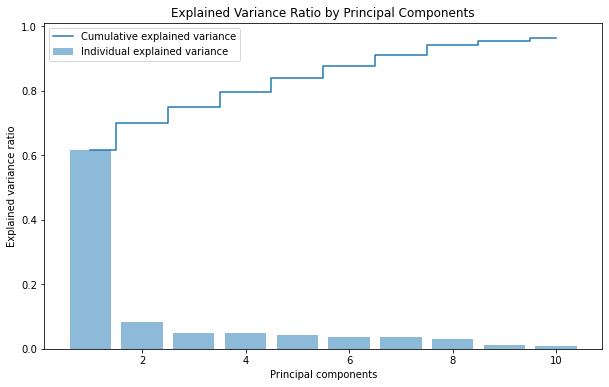

In [51]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.legend(loc='best')
plt.show()

I trained a random forest regressor on the top 10 principal components and the results came fast enough (as shown below). But the lstm gave better results on the test set as compared to random forest regressor (this model was to predict the new number of deaths everyday)

In [52]:
rf_regressor = RandomForestRegressor(n_estimators=30, random_state=42)  # You can adjust hyperparameters as needed
rf_regressor.fit(X_train_pca, y_death_train)

y_pred = rf_regressor.predict(X_test_pca)
mse = mean_squared_error(y_death_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 186.64547183828708


I trained a random forest regressor on the top 10 principal components for the new number of cases of COVID everyday. But the lstm gave much better results on the test set as compared to random forest regressor (this model was to predict the new number of cases everyday)

In [53]:
rf_regressor = RandomForestRegressor(n_estimators=30, random_state=42)  # You can adjust hyperparameters as needed
rf_regressor.fit(X_train_pca, y_cases_train)

y_pred = rf_regressor.predict(X_test_pca)
mse = mean_squared_error(y_cases_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 687670.6335531049


### End of analysis